In [74]:
import os
import pandas as pd

In [75]:
def parse_species_scores(path_file):
    all_samples = {}

    with open(path_file, "r") as f:
        for line in f:
            path = line.strip()

            try:
                df = pd.read_csv(path, sep="\t", usecols=["Genus", "score"])
            except Exception as e:
                print(f"Error reading {path}: {e}")
                continue
            
            sample_name = os.path.basename(os.path.dirname(path))

            # Aggregate by Genus (in case there are duplicates in a sample)
            genus_scores = df.groupby("Genus")["score"].sum()

            all_samples[sample_name] = genus_scores

    # Merge all into a single DataFrame
    merged_df = pd.DataFrame(all_samples).fillna(0).astype(int)
    merged_df.index.name = "Genus"
    merged_df = merged_df[(merged_df != 0).any(axis=1)]
    return merged_df

merged_scores = parse_species_scores("all_species_under_genus_paths.txt")


In [76]:
# parse ground truth from gargammel out
from pathlib import Path
import re
file = Path("/scratch/10169/aranyad2949/kraken_aDNA_test/simulated/gargammel_output") 

with file.open("r") as f:
    lines = f.readlines()

data = []
current_sample = None
sample_pattern = re.compile(r"######## SIMULATING SAMPLE (\d+) WITH GARGAMMEL ########")
bact_pattern = re.compile(
    r"\d+\s+\(\s*([\d.]+)%\)\s+bactaminant fragments from file: ancient/bact/(.+\.fna)"
)

for line in lines:
    sample_match = sample_pattern.search(line)
    if sample_match:
        current_sample = f"sample{sample_match.group(1)}"
        continue

    if current_sample:
        bact_match = bact_pattern.search(line)
        if bact_match:
            percent = float(bact_match.group(1))
            filename = bact_match.group(2)
            data.append({"sample": current_sample, "file": filename, "percentage": percent})


df = pd.DataFrame(data)
df = df.pivot(index="file", columns="sample", values="percentage").fillna(0)

df = df.copy()
df['genus'] = df.index.str.split('_').str[0]

df.set_index("genus", inplace=True)
presence_absence_df = df.groupby("genus").max() > 0
    

In [77]:
def fscore(boolean_test, presence_absence_df):
    all_genera = boolean_test.index.union(presence_absence_df.index)
    all_samples = boolean_test.columns.union(presence_absence_df.columns)

    boolean_test = boolean_test.reindex(index=all_genera, columns=all_samples, fill_value=False)
    boolean_ground_truth = presence_absence_df.reindex(index=all_genera, columns=all_samples, fill_value=False)

    TP = (boolean_test & boolean_ground_truth).sum(axis=0)
    FP = (boolean_test & (~boolean_ground_truth)).sum(axis=0)
    FN = ((~boolean_test) & boolean_ground_truth).sum(axis=0)

    f1 = (2 * TP) / (2 * TP + FP + FN)
    f1 = f1.fillna(0).round(3)

    results_df = pd.DataFrame({
        "Sample": TP.index,
        "TP": TP.values,
        "FP": FP.values,
        "FN": FN.values,
        "F1": f1.values
    })

    return results_df

In [78]:
ameta_df = pd.read_csv("../aMeta/results/overview_heatmap_scores.txt", sep="\t", index_col=0)
ameta_df.index = ameta_df.index.str.strip().str.split().str[0]
ameta_df = ameta_df.groupby(ameta_df.index).max()
boolean_test = ameta_df > 7  
ameta_score = fscore(boolean_test, presence_absence_df)


In [ ]:
test_df = pd.read_csv("aggregated_scores.csv", index_col=0)
boolean_test = test_df > 3  
MATclassifier_score = fscore(boolean_test, presence_absence_df)

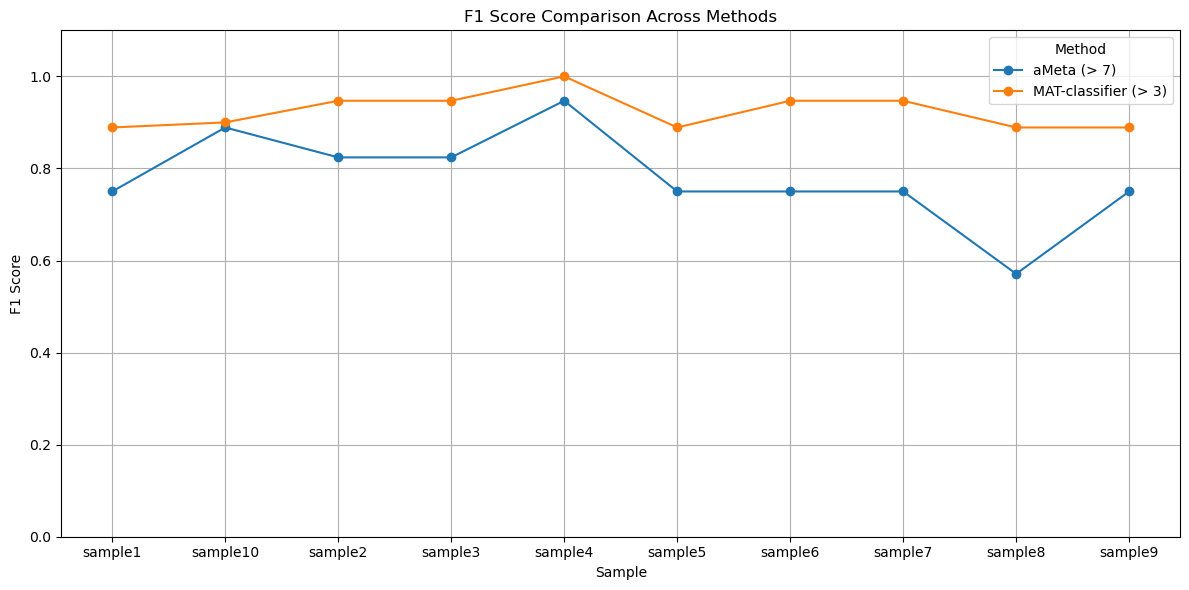

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

ameta_score['Method'] = 'aMeta (> 7)'
MATclassifier_score['Method'] = 'MAT-classifier (> 3)'

ameta_score.sort_values(by='Sample', inplace=True)
MATclassifier_score.sort_values(by='Sample', inplace=True)

combined_df = pd.concat([ameta_score, MATclassifier_score])

plt.figure(figsize=(12, 6))
for method in combined_df['Method'].unique():
    subset = combined_df[combined_df['Method'] == method]
    plt.plot(subset['Sample'], subset['F1'], marker='o', label=method)

plt.title('F1 Score Comparison Across Methods')
plt.xlabel('Sample')
plt.ylabel('F1 Score')
plt.xticks(rotation=0)
plt.ylim(0, 1.1)
plt.legend(title="Method")
plt.grid(True)
plt.tight_layout()
plt.show()


In [81]:
from scipy.stats import wilcoxon
pivot_df = combined_df.pivot(index="Sample", columns="Method", values="F1")
methods = pivot_df.columns.tolist()
# tests one-tailed hypothesis that aMeta (> 7) is performing worse than MAT-classifier (> 3)
stat, p_value = wilcoxon(pivot_df['aMeta (> 7)'], pivot_df['MAT-classifier (> 3)'], alternative='less')
print(f"Wilcoxon test p-value: {p_value:.4f}")

Wilcoxon test p-value: 0.0010


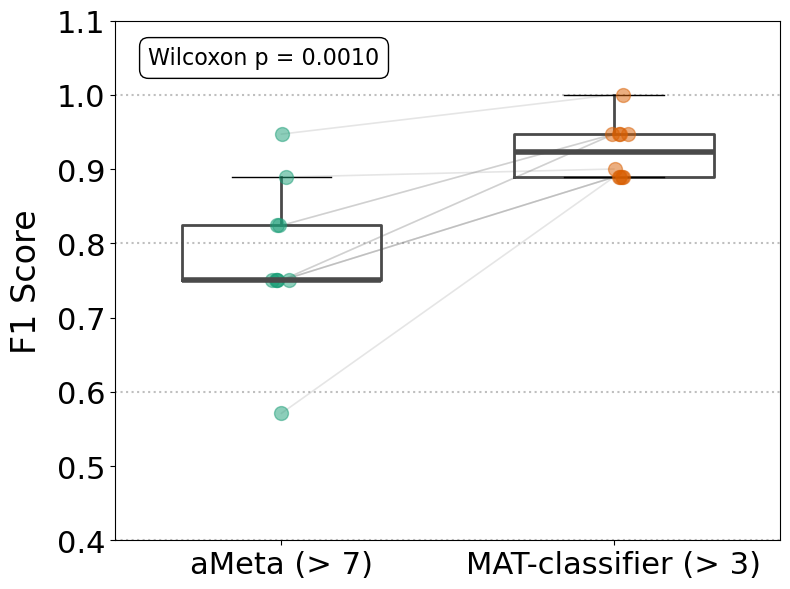

In [82]:
import matplotlib.pyplot as plt
import numpy as np

methods = combined_df['Method'].unique()
colors = ["#1B9E77", "#D95F02"]
data = [combined_df.loc[combined_df.Method==m, 'F1'].values for m in methods]

fig, ax = plt.subplots(figsize=(8,6))
ax.set_facecolor('#ffffff')
fig.patch.set_facecolor('#ffffff')

for y in (0.2, 0.4, 0.6, 0.8, 1.0):
    ax.axhline(y, color='#b0b0b0', ls=':', alpha=0.8, zorder=0)

ax.boxplot(
    data,
    positions=range(len(methods)),
    widths=0.6,
    showfliers=False,
    medianprops=dict(linewidth=4, color='#4a4a4a'),
    whiskerprops=dict(linewidth=2, color='#4a4a4a'),
    boxprops=dict(linewidth=2, color='#4a4a4a'),
    showcaps=True,
)

# jittered scatter
for i, ys in enumerate(data):
    x = np.random.normal(i, 0.02, size=len(ys))
    ax.scatter(x, ys, s=100, color=colors[i], alpha=0.5, zorder=2)

# connect same samples with lines
pivot_df = combined_df.pivot(index="Sample", columns="Method", values="F1")

x_positions = {'aMeta (> 7)': 0, 'MAT-classifier (> 3)': 1}

for sample, row in pivot_df.iterrows():
    if row.isnull().any():
        continue
    x0, x1 = x_positions['aMeta (> 7)'], x_positions['MAT-classifier (> 3)']
    y0, y1 = row['aMeta (> 7)'], row['MAT-classifier (> 3)']
    linestyle = '-' if y1 > y0 else '--'   # dash line to show no improvement
    ax.plot([x0, x1], [y0, y1], color='grey', linestyle=linestyle, alpha=0.2, linewidth=1.2, zorder=1)



ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, fontsize=24)
ax.tick_params(labelsize=22)
ax.set_ylabel('F1 Score', fontsize=24, labelpad=10)
ax.set_ylim(0.4, 1.1)
ax.set_xlim(-0.5, len(methods)-0.5)
#ax.set_title('F1 Score Comparison', fontsize=30)
ax.grid(False)
# Adding the p-value annotation
text = f"Wilcoxon p = {p_value:.4f}"
ax.text(
    0.05, 0.95, text, transform=ax.transAxes, fontsize=16, ha="left", va="top",
    bbox=dict(
        facecolor='white',
        edgecolor='black',
        boxstyle='round,pad=0.4',
        linewidth=1
    )
)

plt.tight_layout()
plt.show()


In [83]:
fig.savefig("f1_comparison.svg", format="svg", bbox_inches="tight", dpi=300)

In [84]:
from sklearn.metrics import roc_curve, auc

all_genera = merged_scores.index.union(presence_absence_df.index)
all_samples = merged_scores.columns.union(presence_absence_df.columns)

gt = presence_absence_df.reindex(index=all_genera, columns=all_samples, fill_value=False)
scores = merged_scores.reindex(index=all_genera, columns=all_samples, fill_value=0)

# Roc curve for MATminer - sample-wise
y_true = gt.values.flatten().astype(int) # Ground truth
y_score = scores.values.flatten() #scores

fpr1, tpr1, thresholds1 = roc_curve(y_true, y_score)
roc_auc1 = auc(fpr1, tpr1)

#Roc curve for MATminer - whole dataset
y_true = gt.any(axis=1).astype(int).values
y_score = scores.max(axis=1).values

fprw1, tprw1, thresholdsw1 = roc_curve(y_true, y_score)
roc_aucw1 = auc(fprw1, tprw1)


In [85]:
# ROC for aMeta - sample-wise
all_genera = ameta_df.index.union(presence_absence_df.index)
gt = presence_absence_df.reindex(index=all_genera, columns=all_samples, fill_value=False)
scores = ameta_df.reindex(index=all_genera, columns=all_samples, fill_value=0)
fpr2, tpr2, _ = roc_curve(gt.values.flatten().astype(int), scores.values.flatten())
roc_auc2 = auc(fpr2, tpr2)

# Roc curve for aMeta - whole dataset
y_true = gt.any(axis=1).astype(int).values
y_score = scores.max(axis=1).values
fprw2, tprw2, thresholdsw2 = roc_curve(y_true, y_score)
roc_aucw2 = auc(fprw2, tprw2)


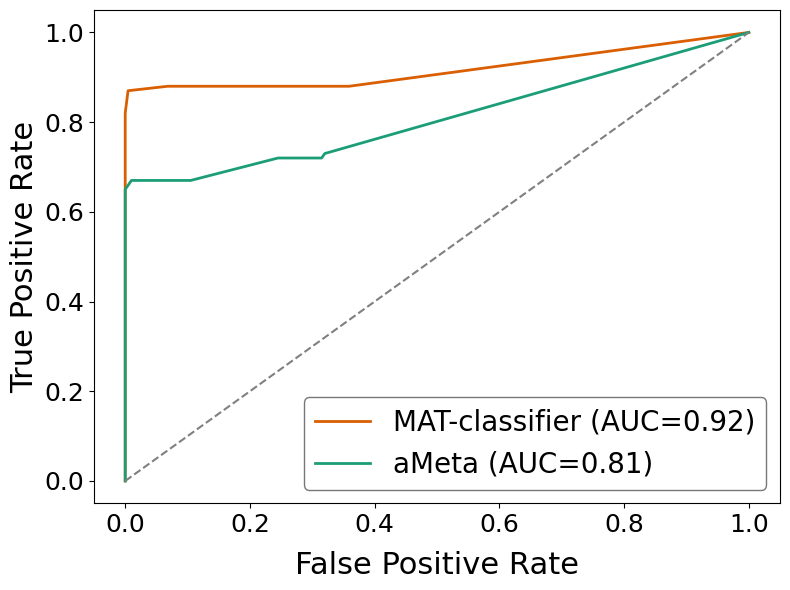

In [86]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(fpr1, tpr1, lw=2, label=f"MAT-classifier (AUC={roc_auc1:.2f})", color="#D95F02")
ax.plot(fpr2, tpr2, lw=2, label=f"aMeta (AUC={roc_auc2:.2f})", color="#1B9E77")
ax.plot([0, 1], [0, 1], "--", color="gray")
ax.set_xlabel("False Positive Rate", fontsize=22, labelpad=10)
ax.set_ylabel("True Positive Rate", fontsize=22)
#ax.set_title("Sample-wise", fontsize=18, pad=15)
ax.tick_params(axis='both', labelsize=18)
leg = ax.legend(fontsize=20, loc="lower right", frameon=True)
leg.get_frame().set_edgecolor("#555555")

plt.tight_layout()
plt.savefig("ROC_comparison.svg", dpi=300, bbox_inches='tight')
plt.show()


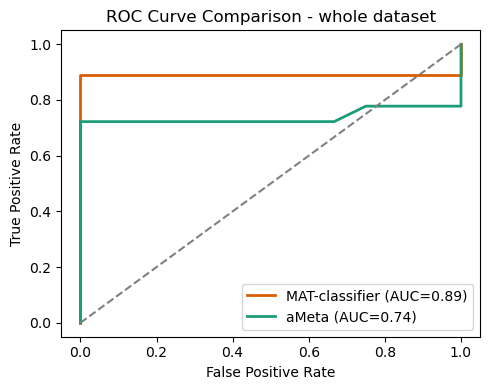

In [87]:
plt.figure(figsize=(5, 4))
plt.plot(fprw1, tprw1, lw=2, label=f"MAT-classifier (AUC={roc_aucw1:.2f})", color="#D95F02")
plt.plot(fprw2, tprw2, lw=2, label=f"aMeta (AUC={roc_aucw2:.2f})", color="#1B9E77")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison - whole dataset")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


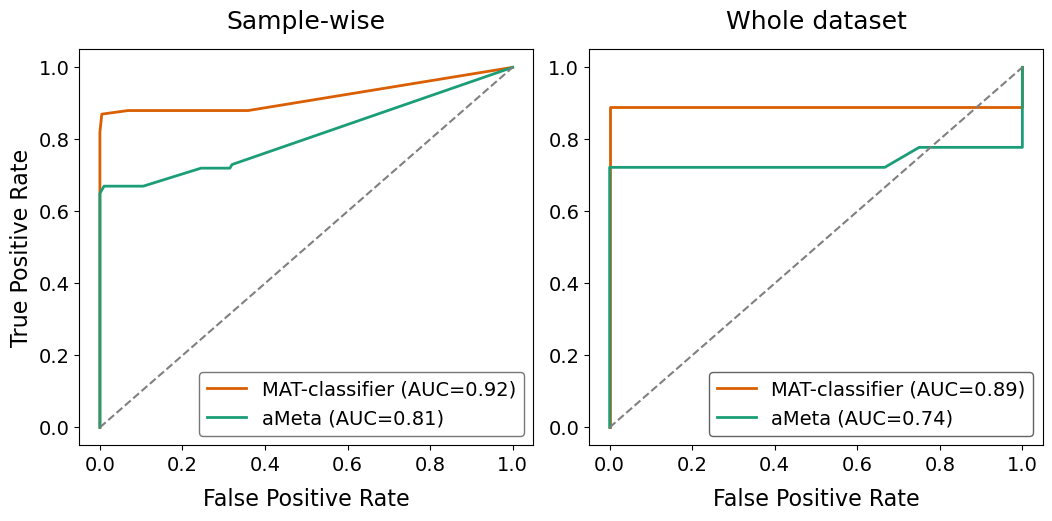

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(90*3 / 25.4, 45*3 / 25.4))  

axes[0].plot(fpr1, tpr1, lw=2, label=f"MAT-classifier (AUC={roc_auc1:.2f})", color="#D95F02")
axes[0].plot(fpr2, tpr2, lw=2, label=f"aMeta (AUC={roc_auc2:.2f})", color="#1B9E77")
axes[0].plot([0, 1], [0, 1], "--", color="gray")
axes[0].set_xlabel("False Positive Rate", fontsize=16, labelpad=10)
axes[0].set_ylabel("True Positive Rate", fontsize=16)
axes[0].set_title("Sample-wise", fontsize=18, pad=15)
axes[0].tick_params(axis='both', labelsize=14)
legend = axes[0].legend(fontsize=14, loc="lower right", frameon=True)
legend.get_frame().set_edgecolor("#555555")


axes[1].plot(fprw1, tprw1, lw=2, label=f"MAT-classifier (AUC={roc_aucw1:.2f})", color="#D95F02")
axes[1].plot(fprw2, tprw2, lw=2, label=f"aMeta (AUC={roc_aucw2:.2f})", color="#1B9E77")
axes[1].plot([0, 1], [0, 1], "--", color="gray")
axes[1].set_xlabel("False Positive Rate", fontsize=16, labelpad=10)
#axes[1].set_ylabel("True Positive Rate", fontsize=16)
axes[1].set_title("Whole dataset", fontsize=18, pad=15)
axes[1].tick_params(axis='both', labelsize=14)
legend = axes[1].legend(fontsize=14, loc="lower right", frameon=True)
legend.get_frame().set_edgecolor("#3C3C3C")


plt.tight_layout()
#plt.savefig("ROC_comparison.svg", dpi=300, bbox_inches='tight')
plt.show()


In [89]:
# parse ground truth from gargammel out
from pathlib import Path
import re
file = Path("/scratch/10169/aranyad2949/kraken_aDNA_test/simulated/gargammel_output") 

with file.open("r") as f:
    lines = f.readlines()

data = []
current_sample = None
sample_pattern = re.compile(r"######## SIMULATING SAMPLE (\d+) WITH GARGAMMEL ########")
bact_pattern = re.compile(
    r"\d+\s+\(\s*([\d.]+)%\)\s+bactaminant fragments from file: modern/bact/(.+\.fna)"
)

for line in lines:
    sample_match = sample_pattern.search(line)
    if sample_match:
        current_sample = f"sample{sample_match.group(1)}"
        continue

    if current_sample:
        bact_match = bact_pattern.search(line)
        if bact_match:
            percent = float(bact_match.group(1))
            filename = bact_match.group(2)
            data.append({"sample": current_sample, "file": filename, "percentage": percent})


modern_gt = pd.DataFrame(data)
modern_gt = modern_gt.pivot(index="file", columns="sample", values="percentage").fillna(0)
modern_gt['genus'] = modern_gt.index.str.split('_').str[0]
modern_gt.set_index("genus", inplace=True)
presence_absence_modern = modern_gt.groupby("genus").max() > 0

In [90]:
gt_all = pd.concat([presence_absence_df, presence_absence_modern])
gt_all = gt_all.groupby(gt_all.index).max()

def global_metrics(gt_df, pipeline_df):
    all_genera = gt_df.index.union(pipeline_df.index)
    gt = gt_df.reindex(all_genera, fill_value=False)
    pred = pipeline_df.reindex(all_genera, fill_value=False)

    gt_global = gt.any(axis=1)
    pred_global = pred.any(axis=1)

    TP = (gt_global & pred_global).sum()
    FP = ((~gt_global) & pred_global).sum()
    FN = (gt_global & ~pred_global).sum()

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    # Jaccard index
    intersection = (gt_global & pred_global).sum()
    union = (gt_global | pred_global).sum()
    jaccard = intersection / union if union > 0 else 0
    return {
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1": round(f1, 3),
        "Jaccard": round(jaccard, 3)
    }

ameta_metrics = global_metrics(gt_all, ameta_df > 4)
MATclassifier_metrics = global_metrics(gt_all, merged_scores > 1)


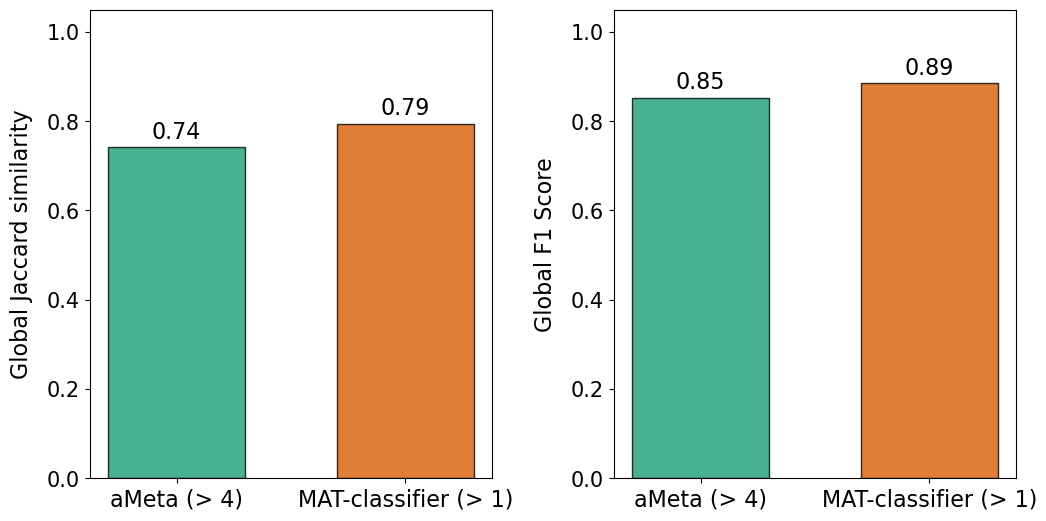

In [91]:
jaccard_scores = [ameta_metrics["Jaccard"], MATclassifier_metrics["Jaccard"]]
f1_scores = [ameta_metrics["F1"], MATclassifier_metrics["F1"]]
methods = ["aMeta (> 4)", "MAT-classifier (> 1)"]
colors = ["#1B9E77", "#D95F02"]

fig, axes = plt.subplots(1, 2, figsize=(90*3 / 25.4, 45*3 / 25.4))  # size in inches
fig.patch.set_facecolor("#ffffff")

ax = axes[0]
x_pos = np.arange(len(methods))
bars = ax.bar(x_pos, jaccard_scores, color=colors, alpha=0.8, edgecolor="black", width=0.6)

for i, v in enumerate(jaccard_scores):
    ax.text(i, v + 0.02, f"{v:.2f}", ha="center", fontsize=16)

ax.tick_params(labelsize=15)
ax.set_xticks(x_pos)
ax.set_xticklabels(methods, fontsize=16, ha="center")
ax.set_ylim(0, 1.05)
ax.set_ylabel("Global Jaccard similarity", fontsize=16, labelpad=10)
ax.grid(False)

#Plot 2: Global F1 Score
ax = axes[1]
x_pos = np.arange(len(methods))
bars = ax.bar(x_pos, f1_scores, color=colors, alpha=0.8, edgecolor="black", width=0.6)

for i, v in enumerate(f1_scores):
    ax.text(i, v + 0.02, f"{v:.2f}", ha="center", fontsize=16)

ax.tick_params(labelsize=15)
ax.set_xticks(x_pos)
ax.set_xticklabels(methods, fontsize=16, ha="center")
ax.set_ylim(0, 1.05)
ax.set_ylabel("Global F1 Score", fontsize=16, labelpad=10)

ax.grid(False)

plt.tight_layout()

# Export to PDF with correct DPI and size
dpi = 300
plt.savefig("detection_comparison.svg", dpi=dpi, bbox_inches='tight')
